In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.neighbors._base # this is from `scikit-learn` instead of `sklearn`
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# 1. Reading the data

In [2]:
# Shortcut to avoid sections 1, 2, and 3
# the file can be found in canvas code submissions :)
data = pd.read_csv("data.csv")

In [26]:
#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

In [27]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [28]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

# 2. Exploratory Analysis

### 2.1 Unbalanced Data

In [29]:
print("Number Connected (Synapses):",data['connected'].sum())
print("Number Not Connected:",(~data['connected']).sum())
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")
print(f"All the connected adps are from {data[data['connected'] == True]['pre_nucleus_id'].nunique()} pre- neurons and {data[data['connected'] == True]['post_nucleus_id'].nunique()} post- neurons.")

Number Connected (Synapses): 1366
Number Not Connected: 184466
All the adps are from 77 pre- neurons and 2663 post- neurons.
All the connected adps are from 72 pre- neurons and 978 post- neurons.


### 2.2 Synaptic Proximity Distance

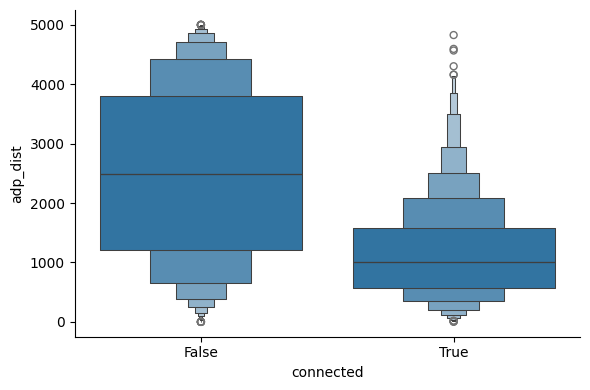

In [30]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen', height=4, aspect=1.5)

Neurons that form a synpase ('connected') tend to be closer together (smaller distance between pre- and post-synaptic ADP - 'adp_dist').

# 3. Feature Engineering

### 3.1 Neurons that form a synpase tend to have similar functional neural responses

Neurons in the visual cortex each respond differently to visual stimuli.  This is often captured by a neuron's tuning function, or the visual features that drive a neuron to fire.  The feature weight vectors ('feature_weights') are a kind of summary of each neuron's tuning function.  Neuroscience suggests that neurons with similar tuning are slightly more likely to be connected.  To assess this, we would need to engineer a new feature that capture the tuning similarity of the pre- and post- synaptic neurons for each ADP.  (See the documentation for more details).  

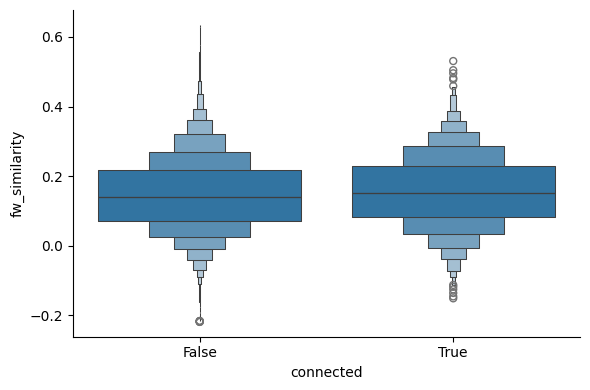

In [31]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)

#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen', height=4, aspect=1.5)

Looks like there is a slight difference.

### 3.2 Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

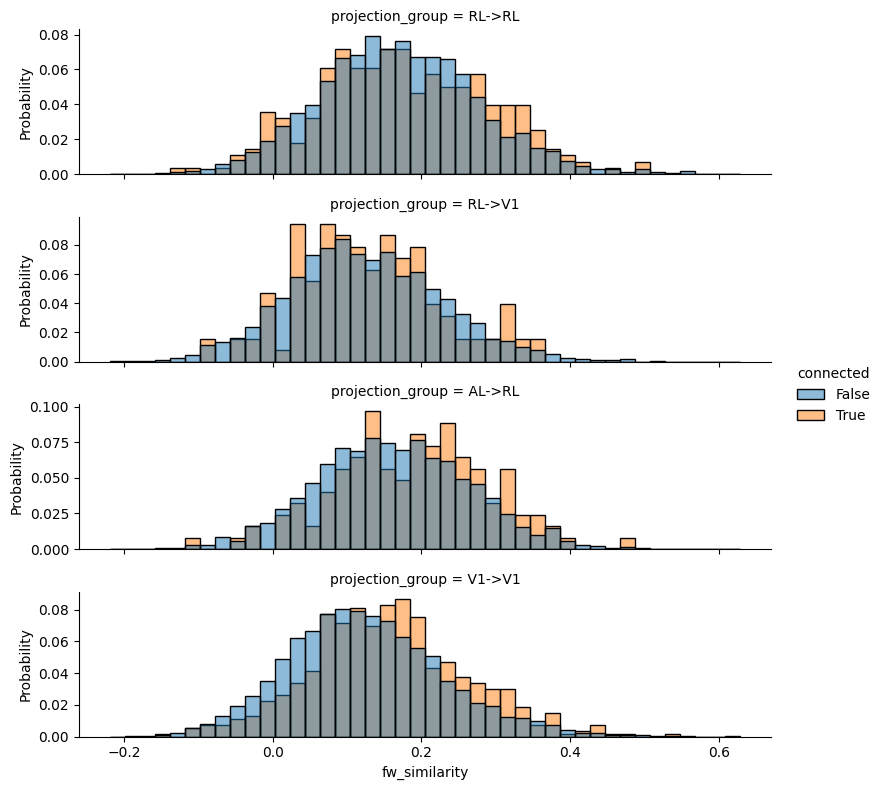

In [9]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'), 
    x='fw_similarity', 
    hue='connected', 
    row='projection_group',
    common_norm=False, 
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False},
)

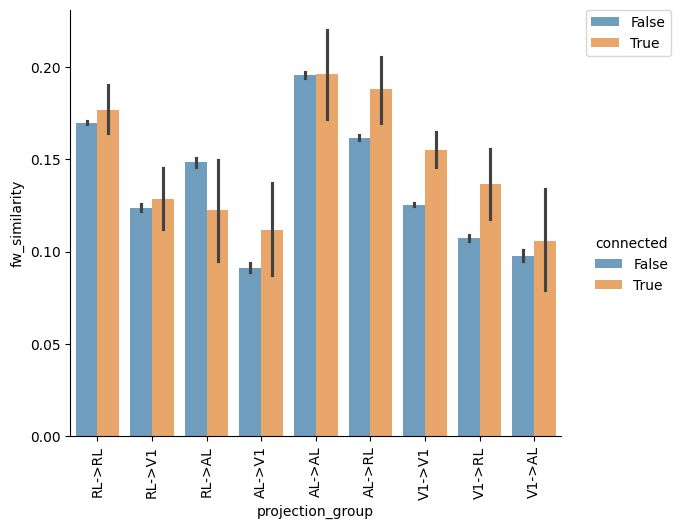

In [10]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

### 3.3 pre-post nucleous ID counts

We add 4 new columns: pre_pre, pre_post, post_post, and post_pre, where i_j counts the number of times the nucleous ID i appears as j in the data. We hypothesize that this can help with understanding the neurons better and differenciating between more and less active neurons.

In [11]:
def count_appearances(row, source_column, target_column):
    mask = data[target_column] == row[source_column]
    count = len(data[target_column][mask])
    return count

data["pre_pre"] = data.apply(lambda row: count_appearances(row, 'pre_nucleus_id', 'pre_nucleus_id'), axis=1)
data["pre_post"] = data.apply(lambda row: count_appearances(row, 'pre_nucleus_id', 'post_nucleus_id'), axis=1)
data["post_pre"] = data.apply(lambda row: count_appearances(row, 'post_nucleus_id', 'pre_nucleus_id'), axis=1)
data["post_post"] = data.apply(lambda row: count_appearances(row, 'post_nucleus_id', 'post_nucleus_id'), axis=1)

We do the same but now only counting the connected pairs

In [12]:
def count_connected_appearances(row, source_column, target_column):
    mask = (data[target_column] == row[source_column]) & (data["connected"] == True)
    count = len(data[target_column][mask])
    return count

data["pre_pre_connect"] = data.apply(lambda row: count_connected_appearances(row, 'pre_nucleus_id', 'pre_nucleus_id'), axis=1)
data["pre_post_connect"] = data.apply(lambda row: count_connected_appearances(row, 'pre_nucleus_id', 'post_nucleus_id'), axis=1)
data["post_pre_connect"] = data.apply(lambda row: count_connected_appearances(row, 'post_nucleus_id', 'pre_nucleus_id'), axis=1)
data["post_post_connect"] = data.apply(lambda row: count_connected_appearances(row, 'post_nucleus_id', 'post_nucleus_id'), axis=1)


### 3.4 Euclidean Distances

Given the x-y-z coordinates of the pre- and post neurons, we create a column for each ADP representing euclidean distances between the pre and post neurons.

In [13]:
pre_coords = data[['pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z']].values
post_coords = data[['post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z']].values

# Calculate Euclidean distance for each row
euclidean_distances = np.linalg.norm(pre_coords - post_coords, axis=1)

# Add a new column to the DataFrame for Euclidean distances
data['euclidean_distance'] = euclidean_distances

### 3.5 Morph Embeddings & Morph Distance

Knowing that some neurons do not have morphological embeddings and have missing values, we mark those cells with NaN. We then calculate the Euclidean distance between pre- and post-morphological embeddings for each ADP, labeling the resulting feature as 'morph_distance.'

However, we later discover that this feature provides only marginal benefits with very low feature importance (see report). Since the following cell requires significant computational power, we will comment it out.


In [15]:
# UNCOMMENT THE FOLLOWING TO RUN:

# def replace_nan_with_array(value):
#     if value is np.nan:
#         a = np.empty(32)
#         a[:] = np.nan
#         return a
#     else:
#         return value

# data['pre_morph_embeddings'] = data['pre_morph_embeddings'].apply(replace_nan_with_array)
# expanded_df = pd.DataFrame(data['pre_morph_embeddings'].tolist(), columns=[f'element_{i+1}' for i in range(32)])

# imputer = MissForest()
# expanded_df = imputer.fit_transform(expanded_df)
# expanded_df = pd.DataFrame(expanded_df)
# data['pre_morph_embeddings'] = expanded_df.apply(lambda row: np.array(row), axis=1)

# # Calculate the distance between two morph embeddings
# def distance1(arr1, arr2):
#     return np.sqrt(np.sum((arr1 - arr2)**2))

# # Calculate Euclidean distance for each row and add as a new column
# data['morph_distance'] = data.apply(lambda row: distance1(row['pre_morph_embeddings'], row['post_morph_embeddings']), axis=1)

### 3.7 One Hot Encoding

Make the following categorical variables interpretable: 'pre_brain_area', 'post_brain_area', "projection_group", "compartment"

In [ ]:
data = data.drop(labels =["pre_feature_weights", "post_feature_weights", "pre_morph_embeddings", "post_morph_embeddings"],axis=1 )
data = pd.get_dummies(data, columns=['pre_brain_area', 'post_brain_area', "projection_group", "compartment"])

# 4. Train, Test, and Validation Split

In this section, we partition our data into training, testing, and validation sets.

It is noteworthy that we are working with a limited 77 unique pre-neurons, in contrast to a more substantial 2663 unique post-neurons. Additionally, we observe a modest 1366 synapses, while a notable 184466 ADPs remain unconnected.

Given our objective of ensuring the model's adaptability to both new (unseen) neurons as well as accurate predictions for familiar  neurons, we crate these sets "by hand" in order to maintain proportional representation of pre-neurons in each set.

To address the imbalance in connectedness, we employ oversampling in the minority class of synapses for select models. This strategic approach is designed to enhance balanced accuracy rather than conventional accuracy.

In [3]:
# Group data by 'pre_nucleus_id' and calculate counts, sums, and percentages for 'connected'
grouped_df = data.groupby('pre_nucleus_id')['connected'].agg(['count', 'sum']).reset_index()
grouped_df.head(4)

,pre_nucleus_id,count,sum
0,189149,4242,32
1,222998,5512,32
2,223037,3108,23
3,224565,1534,13


In [4]:
# Create a dictionary to store counts, sums, and percentages for each 'pre_nucleus_id'
result_dict = {row['pre_nucleus_id']: [row['count'], row['sum'], (row['sum'] / row['count']) * 100] for _, row in grouped_df.iterrows()}
# Sort the dictionary by percentage (third element in the value array)
original_dict = dict(sorted(result_dict.items(), key=lambda item: item[1][2], reverse=True))
original_dict

{269247: [956, 29, 3.0334728033472804],
 330079: [3308, 63, 1.9044740024183797],
 330326: [1834, 33, 1.7993456924754636],
 258307: [4277, 64, 1.4963759644610708],
 612352: [745, 10, 1.342281879194631],
 553585: [1268, 16, 1.2618296529968454],
 518898: [3541, 40, 1.1296243998870377],
 271518: [534, 6, 1.1235955056179776],
 557030: [3764, 40, 1.0626992561105209],
 558709: [2493, 26, 1.0429201764941836],
 292685: [8783, 88, 1.0019355573266537],
 296726: [4236, 40, 0.9442870632672332],
 583961: [5958, 56, 0.9399127223900637],
 489675: [2247, 21, 0.9345794392523363],
 516758: [4144, 38, 0.916988416988417],
 294776: [5018, 46, 0.9166998804304504],
 518134: [1934, 17, 0.8790072388831437],
 294858: [2876, 25, 0.8692628650904033],
 554200: [2670, 23, 0.8614232209737828],
 301095: [2939, 25, 0.8506294658046955],
 493885: [1179, 10, 0.8481764206955046],
 224565: [1534, 13, 0.847457627118644],
 610615: [1213, 10, 0.8244023083264632],
 518848: [3940, 32, 0.8121827411167513],
 588839: [2466, 20, 0.8

In [5]:
# Calculate the sum of the first elements in the original dictionary
original_sum_first_elements = sum(value[0] for value in original_dict.values())

# Step 2: Identify and remove 15 keys from the original dictionary (randomly selected)
num_keys_to_remove = 15

# Create a new dictionary with the removed keys
# such that the summation of the first elements is 1/5 times the original summation
target_sum_first_elements = original_sum_first_elements / 5
current_sum = 0

while current_sum < target_sum_first_elements:
    # Randomly select 15 keys to remove
    keys_to_remove = random.sample(list(original_dict.keys()), num_keys_to_remove)
    
    # Create a removed dictionary
    removed_dict = {key: original_dict.pop(key) for key in keys_to_remove}
    
    # Update current_sum
    current_sum = sum(value[0] for value in removed_dict.values())

# Create a new dictionary with the removed keys
new_dict = removed_dict


In [6]:
# Extract values from the removed dictionary to create a test dataset
values_list = list(removed_dict.keys())
test_data = data[data['pre_nucleus_id'].isin(values_list)]
# Create a training and validation dataset excluding the removed keys
train_val_data = data[~data['pre_nucleus_id'].isin(values_list)]

In [7]:
# Now that we have created a train set, let's do the same for validation

grouped_df = train_val_data.groupby('pre_nucleus_id')['connected'].agg(['count', 'sum']).reset_index()

result_dict = {}
for _, row in grouped_df.iterrows():
    count, y_sum = row['count'], row['sum']
    percentage = (y_sum / count) * 100
    result_dict[row['pre_nucleus_id']] = [count, y_sum, percentage]

# Sort the dictionary by the third element in the value array
original_dict = dict(sorted(result_dict.items(), key=lambda item: item[1][2], reverse=True))


original_sum_first_elements = sum(value[0] for value in original_dict.values())

# Step 2: Identify and remove 15 keys from the original dictionary (randomly selected)
num_keys_to_remove = 15

# Step 3: Create a new dictionary with the removed keys
# such that the summation of the first elements is 1/4 times the original summation
target_sum_first_elements = original_sum_first_elements / 4
current_sum = 0

while current_sum < target_sum_first_elements:
    # Randomly select 15 keys to remove
    keys_to_remove = random.sample(list(original_dict.keys()), num_keys_to_remove)
    
    # Create a removed dictionary
    removed_dict = {key: original_dict.pop(key) for key in keys_to_remove}
    
    # Update current_sum
    current_sum = sum(value[0] for value in removed_dict.values())

# Create a new dictionary with the removed keys
new_dict = removed_dict

values_list =list(removed_dict.keys())

validation_data = train_val_data[train_val_data['pre_nucleus_id'].isin(values_list)]
train_data = train_val_data[~train_val_data['pre_nucleus_id'].isin(values_list)]

In [8]:
from sklearn.model_selection import PredefinedSplit

x_train = train_data.drop(labels = "connected",axis = 1)
x_train = StandardScaler().fit_transform(x_train)
y_train = train_data["connected"]

x_val = validation_data.drop(labels = "connected",axis = 1)
x_val = StandardScaler().fit_transform(x_val)
y_val =validation_data["connected"]


x_test = test_data.drop(labels = "connected",axis = 1)
x_test =  StandardScaler().fit_transform(x_test)
y_test = test_data["connected"]

x_comb = np.vstack((x_train, x_val))
y_comb = np.concatenate((y_train, y_val))

In [36]:
cols = ['Unnamed: 0', 'ID', 'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z',
       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z', 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'pre_test_score', 'pre_rf_x', 'pre_rf_y', 'post_oracle',
       'post_test_score', 'post_rf_x', 'post_rf_y', 'pre_nucleus_x',
       'pre_nucleus_y', 'pre_nucleus_z', 'post_nucleus_x', 'post_nucleus_y',
       'post_nucleus_z', 'pre_nucleus_id', 'post_nucleus_id',
       'fw_similarity', 'pre_pre', 'pre_post', 'post_pre', 'post_post',
       'euclidean_distance', 'morph_distance', 'pre_brain_area_AL',
       'pre_brain_area_RL', 'pre_brain_area_V1', 'post_brain_area_AL',
       'post_brain_area_RL', 'post_brain_area_V1', 'projection_group_AL->AL',
       'projection_group_AL->RL', 'projection_group_AL->V1',
       'projection_group_RL->AL', 'projection_group_RL->RL',
       'projection_group_RL->V1', 'projection_group_V1->AL',
       'projection_group_V1->RL', 'projection_group_V1->V1',
       'compartment_apical', 'compartment_apical_shaft',
       'compartment_apical_tuft', 'compartment_axon', 'compartment_basal',
       'compartment_oblique', 'compartment_soma']

# 5. Model Training

### 5.1 Balanced Random Forest

The piece of code below is responsible for implementing cross-validation for a balanced random forest. 
Due to its time-intensive nature, we have commented it out. 
Instead, we will create a model using the best parameters identified through cross-validation, as outlined below.

In [13]:
# # Create a list indicating the fold to which each sample belongs (0 for training, 1 for validation)
# test_fold = [-1] * len(x_train) + [0] * len(x_val)

# # Create the PredefinedSplit object
# ps = PredefinedSplit(test_fold)

# brf = BalancedRandomForestClassifier()

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['log2', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# #Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#               'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                 'bootstrap': bootstrap}


# brf_model = RandomizedSearchCV(estimator = brf, param_distributions = random_grid,scoring = 'balanced_accuracy', n_iter = 100, cv=ps, verbose=2, random_state=42, n_jobs = -1)
# brf_model.fit(x_comb,y_comb)
# print(brf_model.best_params_)

# best_params = brf_model.best_params_

# # Train the final brf_model with the best hyperparameters on the entire training set
# brf_model = BalancedRandomForestClassifier(**best_params)



# X_test_selected = x_test

# lb_selected = StandardScaler().fit_transform(lb_data)

# data_train = data.drop(labels = "connected",axis = 1)
# data_selected =  StandardScaler().fit_transform(data_train)


In [10]:
best_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 7, 'bootstrap': False}
brf_model = BalancedRandomForestClassifier(**best_params)
brf_model.fit(x_comb, y_comb)

# predict on test data
pred = brf_model.predict_proba(x_test)[:, 1]

In [11]:
# compute accuracy
print(f"accuracy: {accuracy_score(y_test, pred > .5)}")

# confusion matrix
print(confusion_matrix(y_test, pred > .5))

# compute balanced accuracy
print(f"balanced accuracy: {balanced_accuracy_score(y_test, pred > .5)}")

accuracy: 0.6960772456055475
[[34221 15020]
 [   57   310]]
balanced accuracy: 0.7698281438116161


The model above has provided us 75.7% on the public and 78% accuracy on the private leaderboard.

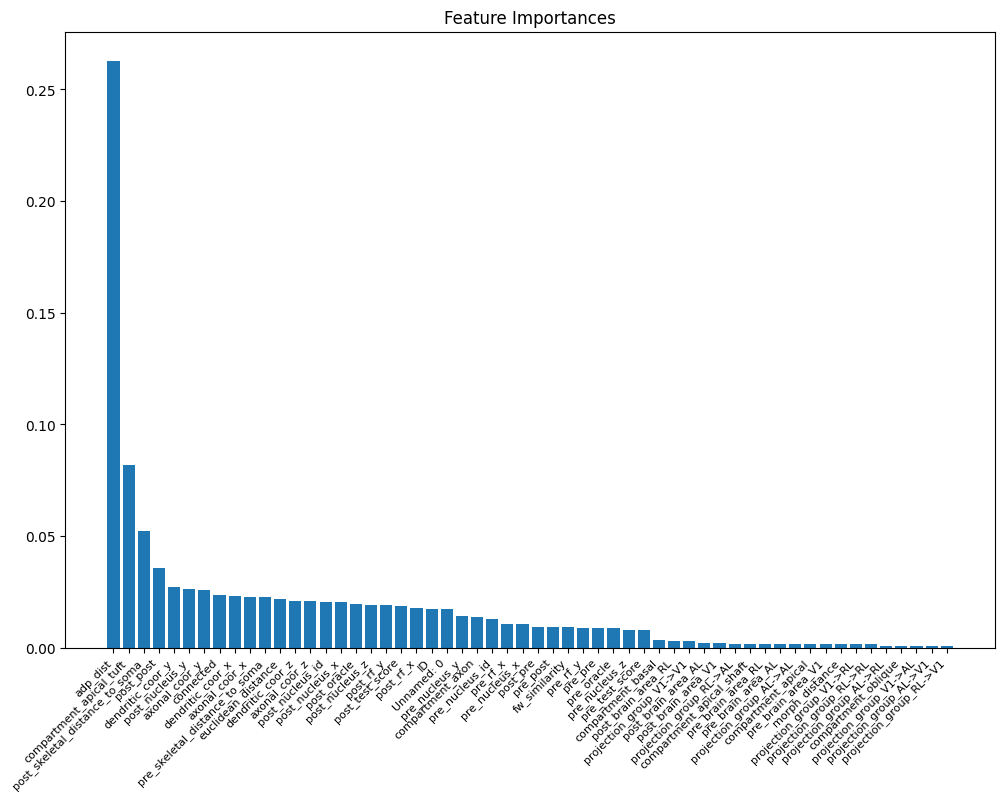

In [12]:
feature_importances = brf_model.feature_importances_
column_names = train_data.columns

# Sort the indices based on feature importances
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances with column names
plt.figure(figsize=(12, 8))
plt.bar(range(x_train.shape[1]), feature_importances[indices])
plt.xticks(range(x_train.shape[1]), [column_names[i] for i in indices], rotation=45, ha="right", fontsize=8)
plt.title("Feature Importances")
plt.show()

### 5.2 Gradient Boosting

In [13]:
# from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import make_scorer, balanced_accuracy_score
# from scipy.stats import randint, uniform

# # Create a list indicating the fold to which each sample belongs (0 for training, 1 for validation)
# test_fold = [-1] * len(x_comb) + [0] * len(x_test)

# # Create the PredefinedSplit object
# ps = PredefinedSplit(test_fold)

# # Define the parameter grid for RandomizedSearchCV
# param_dist = {
#     'n_estimators': randint(100, 2000),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': randint(10, 100),
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'learning_rate': uniform(0.001, 1.0)
# }

# # Create a GradientBoostingClassifier
# gb_model = GradientBoostingClassifier()

# # Define scoring metric
# scorer = make_scorer(balanced_accuracy_score)

# # Create RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     gb_model, param_distributions=param_dist, n_iter=10,
#     scoring=scorer, n_jobs=-1, cv=ps, verbose=2, random_state=42
# )

# # Fit the RandomizedSearchCV
# random_search.fit(x_comb, y_comb)

# # Get the best parameters
# best_params_gb = random_search.best_params_
# print("Best Parameters from Cross-Validation:", best_params_cv)

# # Instantiate the model with the best parameters
# gb_model_cv = GradientBoostingClassifier(**best_params_cv)

In [ ]:
best_params_gb = {"n_estimators" = 1800, "min_samples_split" = 10, "min_samples_leaf" = 4, "max_features" = 'log2', "max_depth"= 88, "learning_rate" = 1}

gb_model = GradientBoostingClassifier(**best_params_gb)

gb_model.fit(x_comb, y_comb)

gb_pred = gb_model.predict_proba(x_test)[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(y_test, gb_pred > .5)}")

# confusion matrix
print(confusion_matrix(y_test, gb_pred > .5))

# compute balanced accuracy
print(f"balanced accuracy: {balanced_accuracy_score(y_test, gb_pred > .5)}")




: 

Ended up giving a very poor accuracy, so we have not used this

### 5.3 Logistic Regression

In [9]:
ros = RandomOverSampler()
x_oversample, y_oversample = ros.fit_resample(x_comb, y_comb)

## Uncomment for CV. Best Params provided below

# # Create a list indicating the fold to which each sample belongs (0 for training, 1 for validation)
# test_fold = [-1] * len(x_train) + [0] * len(x_val)

# # Create the PredefinedSplit object
# ps = PredefinedSplit(test_fold)
# lr_model = LogisticRegression()


# random_grid = {'C': [0.25,0.50,0.75,1,2,5,10,25,50,100,250,500,1000,2500,5000,7500,10000],'max_iter': [1000,2500,5000,10000]}

# # fit model
# #_comb will be used to train model when predicting test test
# x_comb = np.vstack((x_train, x_val))
# y_comb = np.concatenate((y_train, y_val))


# model = RandomizedSearchCV(estimator = lr_model, param_distributions = random_grid,scoring = 'balanced_accuracy', n_iter = 100, cv=ps, verbose=2, random_state=42, n_jobs = -1)
# model.fit(x_comb,y_comb)
# print(model.best_params_)

# best_params = model.best_params_

In [10]:
# Train the final model with the best hyperparameters on the entire training set
best_params_lr = {'max_iter': 1000, 'C': 0.25, 'penalty': 'l1', 'solver': 'liblinear'}
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(x_oversample, y_oversample)

LogisticRegression(C=0.25, max_iter=1000, penalty='l1', solver='liblinear')

In [11]:
lr_pred = lr_model.predict_proba(x_test)[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(y_test, lr_pred > .5)}")

# confusion matrix
print(confusion_matrix(y_test, lr_pred > .5))

# compute balanced accuracy
print(f"balanced accuracy: {balanced_accuracy_score(y_test, lr_pred > .5)}")

accuracy: 0.7203797106966121
[[30021 11679]
 [   74   258]]
balanced accuracy: 0.7485182456444484


The model above model has provided accuracies ranging from 73% to 79% on public and private leaderboards, depending on the features selected.

In [35]:
coefficients = lr_model.coef_[0]
feature_names = cols 

# Create a DataFrame to display coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients to highlight the most influential features
coefficients_df['AbsoluteCoefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='AbsoluteCoefficient', ascending=False)

# Display the sorted DataFrame
print(coefficients_df)

                           Feature  Coefficient  AbsoluteCoefficient
19                   pre_nucleus_x     3.240407             3.240407
52                compartment_axon    -2.367459             2.367459
25                  pre_nucleus_id    -2.252079             2.252079
36               pre_brain_area_V1     1.708828             1.708828
8                         adp_dist    -1.523651             1.523651
39              post_brain_area_V1    -1.298799             1.298799
35               pre_brain_area_RL     1.297600             1.297600
44         projection_group_RL->RL    -1.164965             1.164965
37              post_brain_area_AL    -0.871541             0.871541
38              post_brain_area_RL    -0.608694             0.608694
26                 post_nucleus_id     0.591244             0.591244
32              euclidean_distance     0.544977             0.544977
47         projection_group_V1->RL    -0.526558             0.526558
3                    axonal_coor_y

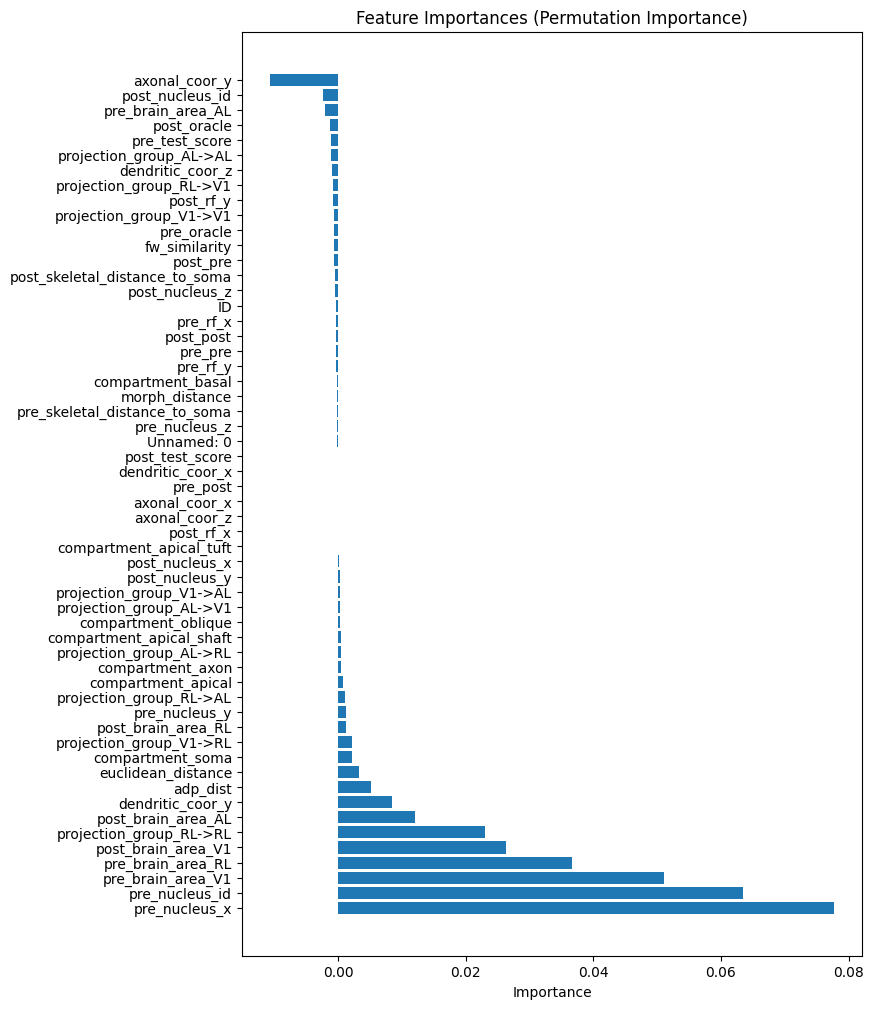

In [54]:
from sklearn.inspection import permutation_importance

# Plot feature importances using permutation_importance
result = permutation_importance(lr_model, x_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to display importances
importances_df = pd.DataFrame({'Feature': cols, 'Importance': result.importances_mean})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the importances
plt.figure(figsize=(8, 12))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances (Permutation Importance)')
plt.show()

### 5.4 Gaussian Naive Bayes

In [ ]:
# Uncomment the following to try CV

# gnb_model = GaussianNB()

# random_grid = {
#     'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Adjust the range based on your problem
# }

# gnb_model = RandomizedSearchCV(estimator = lr, param_distributions = random_grid,scoring = 'balanced_accuracy', n_iter = 100, cv=ps, verbose=2, random_state=42, n_jobs = -1)
# gnb_model.fit(x_oversample, y_oversample)
# gnb_model(gnb_model.best_params_)

# best_params = gnb_model.best_params_


In [18]:
best_params_gnb = {'max_iter': 1000, 'C': 0.25, 'penalty': 'l1', 'solver': 'liblinear'}
gnb_model = LogisticRegression(**best_params_gnb)
gnb_model.fit(x_oversample, y_oversample)

gnb_pred = lr_model.predict_proba(x_test)[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(y_test, gnb_pred > .5)}")

# confusion matrix
print(confusion_matrix(y_test, gnb_pred > .5))

# compute balanced accuracy
print(f"balanced accuracy: {balanced_accuracy_score(y_test, gnb_pred > .5)}")

accuracy: 0.7274941308115935
[[32890 12325]
 [   95   267]]
balanced accuracy: 0.7324912648775066


We have never uploaded this model to kaggle and only created it for stacking.

# Leaderboard Data

In [35]:


lb_data = pd.read_csv("./leaderboard_data.csv")
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

#THIS IS ALSO SOMETHING GENEVERA GAVE
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)

#THIS IS SOMETHING GENEVERA GAVE
# generate projection group as pre->post
lb_data["projection_group"] = (
    lb_data["pre_brain_area"].astype(str)
    + "->"
    + lb_data["post_brain_area"].astype(str)
)


#YOU KNOW THESE 4 COUNTERS
def pre_pre(row):
    mask = lb_data['pre_nucleus_id'] == row['pre_nucleus_id']
    count = len(lb_data['pre_nucleus_id'][mask])
    return count

lb_data["pre_pre"] = lb_data.apply(pre_pre, axis=1)

def pre_post(row):
    mask = lb_data['post_nucleus_id'] == row['pre_nucleus_id']
    count = len(lb_data['post_nucleus_id'][mask])
    return count

lb_data["pre_post"] = lb_data.apply(pre_post, axis=1)

def post_pre(row):
    mask = lb_data['pre_nucleus_id'] == row['post_nucleus_id']
    count = len(lb_data['pre_nucleus_id'][mask])
    return count

lb_data["post_pre"] = lb_data.apply(post_pre, axis=1)

def post_post(row):
    mask = lb_data['post_nucleus_id'] == row['post_nucleus_id']
    count = len(lb_data['post_nucleus_id'][mask])
    return count

lb_data["post_post"] = lb_data.apply(post_post, axis=1)

#IN THIS PART FOR EACH ROW I CALCULATE EUCLIDEAN DISTANCE BETWEEN NUCLEUS
pre_coords = lb_data[['pre_nucleus_x', 'pre_nucleus_y', 'pre_nucleus_z']].values
post_coords = lb_data[['post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z']].values

# Calculate Euclidean distance for each row
euclidean_distance = np.linalg.norm(pre_coords - post_coords, axis=1)

# Add a new column to the DataFrame for Euclidean distances
lb_data['euclidean_distance'] = euclidean_distance


# #This part fills missing values with nan values for morph embeddings
# def replace_nan_with_array(value):
#     if value is np.nan:
#         a = np.empty(32)
#         a[:] = np.nan
#         return a
#     else:
#         return value

# #IN THIS LINE I REPLACE EMPTY LINES WITH EMPTY ARRAYS
# lb_data['pre_morph_embeddings'] = lb_data['pre_morph_embeddings'].apply(replace_nan_with_array)

# #I MAKE MY COLUMN TO NX32 MATRIX TO IMPUTE MISSING VALUES
# expanded_df = pd.DataFrame(lb_data['pre_morph_embeddings'].tolist(), columns=[f'element_{i+1}' for i in range(32)])

# #I IMPUTE MISSING VALUES IN THIS PART AND PUT IT IN MY COLUMN
# imputer = MissForest()
# expanded_df = imputer.fit_transform(expanded_df)
# expanded_df = pd.DataFrame(expanded_df)
# lb_data['pre_morph_embeddings'] = expanded_df.apply(lambda row: np.array(row), axis=1)

# #I CALCULATE DISTANCE BETWEEN MORPH EMBEDDINGS, SOMETHIN CHATGPT RECOMMENDED
# def distance1(arr1, arr2):
#     return np.sqrt(np.sum((arr1 - arr2)**2))

# # Calculate Euclidean distance for each row and add as a new column
# lb_data['morph_distance'] = lb_data.apply(lambda row: distance1(row['pre_morph_embeddings'], row['post_morph_embeddings']), axis=1)

#DROP ROWS WITH ARRAYS THAT CANNOT BE HOTCODED AND HOTCODE ELSE
lb_data = lb_data.drop(labels =["pre_feature_weights", "post_feature_weights", "pre_morph_embeddings", "post_morph_embeddings"],axis=1 )
lb_data = pd.get_dummies(lb_data, columns=['pre_brain_area', 'post_brain_area', "projection_group", "compartment"]) 

In [49]:
cols = lb_data.columns

best_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 7, 'bootstrap': False}
brf_model = BalancedRandomForestClassifier(**best_params)
brf_model.fit(data[cols], data["connected"])

# predict on test data
lb_data["pred"] = brf_model.predict_proba(lb_data)[:, 1]
lb_data["connected"] = lb_data["pred"] > .5

submission_data = lb_data.filter(['ID','connected'])

In [51]:
submission_data.to_csv('rbf_submission.csv',index=False)

# Private accuracy: 0.788%